In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sdv.single_table import TVAESynthesizer
from sdv.metadata import Metadata
from xgboost import XGBClassifier
from skopt import BayesSearchCV

pd.set_option('display.max_columns', None)


In [27]:
# Load data
df = pd.read_csv(
    "../../data/Angoss Knowledge Seeker - carclaims.txt/carclaims_original.csv"
)
# Drop row with missing data
df.drop(df[df["DayOfWeekClaimed"] == "0"].index, inplace=True)
# Drop ID column
df.drop(columns="PolicyNumber", inplace=True)
# df.drop(columns="Age", inplace=True)

# Train-test split
carclaims_train, carclaims_test = train_test_split(df, test_size=0.2, random_state=141)

In [3]:
carclaims_train.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
RepNumber                int64
Deductible               int64
DriverRating             int64
Days:Policy-Accident    object
Days:Policy-Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange-Claim     object
NumberOfCars            object
Year                     int64
BasePolicy              object
FraudFound              object
dtype: object

In [4]:
carclaims_train['DriverRating'].value_counts()

DriverRating
1    3174
3    3097
4    3036
2    3028
Name: count, dtype: int64

In [28]:
synthesizer = TVAESynthesizer.load(
    filepath='my_synthesizer_92_8.pkl'
)

synthetic_data = synthesizer.sample(
    num_rows=100_000,
    batch_size=1_000
)

X_train = synthetic_data.drop('FraudFound', axis=1)
y_train = synthetic_data['FraudFound']

X_test = carclaims_test.drop('FraudFound', axis=1)
y_test = carclaims_test['FraudFound']

# Encode target variable
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Label Encode features
column_labels = {
    'AgeOfPolicyHolder': ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65'],
    'NumberOfSuppliments': ['none', '1 to 2', '3 to 5', 'more than 5'],
    'AddressChange-Claim': ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years'],
    'NumberOfCars': ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    'VehiclePrice': ['less than 20,000', '20,000 to 29,000', '30,000 to 39,000', '40,000 to 59,000', '60,000 to 69,000', 'more than 69,000'],
    'Days:Policy-Accident': ['none', '1 to 7', '15 to 30', '8 to 15', 'more than 30'],
    'Days:Policy-Claim': ['15 to 30', '8 to 15', 'more than 30'],
    'PastNumberOfClaims': ['none', '1', '2 to 4', 'more than 4'],
    'AgeOfVehicle': ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7'],
    'Deductible': [300, 400, 500, 700]
    }
for column, labels in column_labels.items():
    oe = OrdinalEncoder(categories=[labels], handle_unknown='error')
    X_train[column] = oe.fit_transform(X_train[[column]])
    X_test[column] = oe.transform(X_test[[column]])
    
# one hot encode
columns_one_hot = {
    'Make': ['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'],
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'DayOfWeek': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'DayOfWeekClaimed': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'MonthClaimed': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'AccidentArea': ['Rural', 'Urban'],
    'Sex': ['Female', 'Male'],
    'MaritalStatus': ['Divorced', 'Married', 'Single', 'Widow'],
    'PoliceReportFiled': ['No', 'Yes'],
    'WitnessPresent': ['No', 'Yes'],
    'AgentType': ['External', 'Internal'],
    'BasePolicy': ['All Perils', 'Collision', 'Liability'],
    'Fault': ['Policy Holder', 'Third Party'],
    'PolicyType': ['Sedan - All Perils', 'Sedan - Collision', 'Sedan - Liability','Sport - All Perils', 'Sport - Collision', 'Sport - Liability', 'Utility - All Perils', 'Utility - Collision', 'Utility - Liability'],
    'VehicleCategory': ['Sedan', 'Sport', 'Utility'],
    'Year': [1994, 1995, 1996],
    #
    
}
for column, labels in columns_one_hot.items():
    ohe = OneHotEncoder(sparse_output=False, categories=[labels], drop='first', handle_unknown='error')
    encoded_nominal = ohe.fit_transform(X_train[[column]])
    X_train = pd.concat([X_train, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]), index=X_train.index)], axis=1)
    encoded_nominal = ohe.transform(X_test[[column]])
    X_test = pd.concat([X_test, pd.DataFrame(encoded_nominal, columns=ohe.get_feature_names_out([column]), index=X_test.index)], axis=1)
X_test.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)
X_train.drop(columns=columns_one_hot.keys(), axis=1, inplace=True)

Sampling rows: 100%|██████████| 100000/100000 [00:10<00:00, 9539.46it/s]


In [199]:
np.sort(df['RepNumber'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [200]:
# scaler = StandardScaler()
# X_train['Age'] = scaler.fit_transform(X_train[['Age']])
# X_test['Age'] = scaler.transform(X_test[['Age']])

In [201]:
X_train

,WeekOfMonth,WeekOfMonthClaimed,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ferrari,Make_Ford,Make_Honda,Make_Jaguar,Make_Lexus,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Porche,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,Month_Feb,Month_Mar,Month_Apr,Month_May,Month_Jun,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,DayOfWeek_Tuesday,DayOfWeek_Wednesday,DayOfWeek_Thursday,DayOfWeek_Friday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeekClaimed_Tuesday,DayOfWeekClaimed_Wednesday,DayOfWeekClaimed_Thursday,DayOfWeekClaimed_Friday,DayOfWeekClaimed_Saturday,DayOfWeekClaimed_Sunday,MonthClaimed_Feb,MonthClaimed_Mar,MonthClaimed_Apr,MonthClaimed_May,MonthClaimed_Jun,MonthClaimed_Jul,MonthClaimed_Aug,MonthClaimed_Sep,MonthClaimed_Oct,MonthClaimed_Nov,MonthClaimed_Dec,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PoliceReportFiled_Yes,WitnessPresent_Yes,AgentType_Internal,BasePolicy_Collision,BasePolicy_Liability,Fault_Third Party,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sport,VehicleCategory_Utility,Year_1995,Year_1996
15180,2,2,1.0,11,1.0,4,4.0,2.0,1.0,5.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
406,1,1,5.0,4,1.0,3,4.0,2.0,3.0,5.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4729,4,1,2.0,14,1.0,2,4.0,2.0,2.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2234,3,2,1.0,2,1.0,4,4.0,2.0,2.0,6.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7375,4,3,2.0,4,1.0,3,4.0,2.0,2.0,6.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14148,3,2,2.0,16,1.0,1,4.0,2.0,1.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14952,3,4,5.0

In [6]:
tsne_model = TSNE(learning_rate=1000)

tsne_features = tsne_model.fit_transform(X_train)

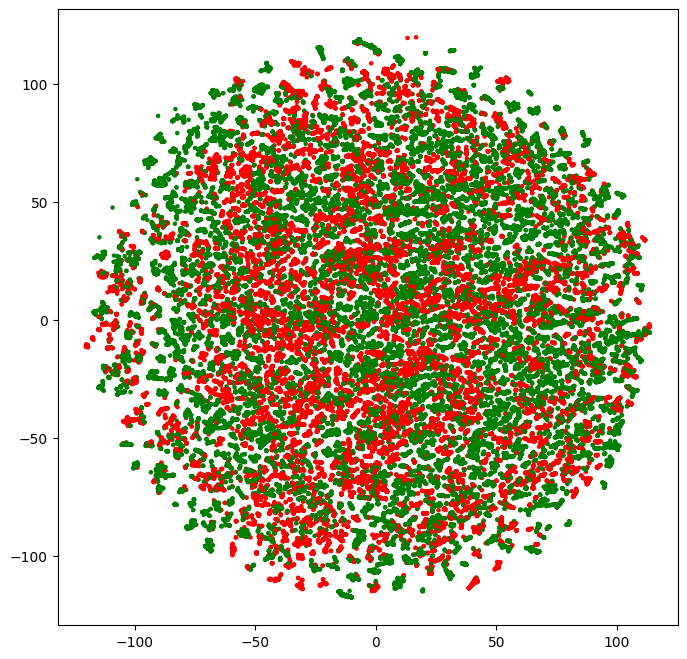

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=y_train.map({0: 'green', 1: 'red'}), s=5)
plt.show()

In [29]:
neighbors = NearestNeighbors(n_neighbors=90)
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

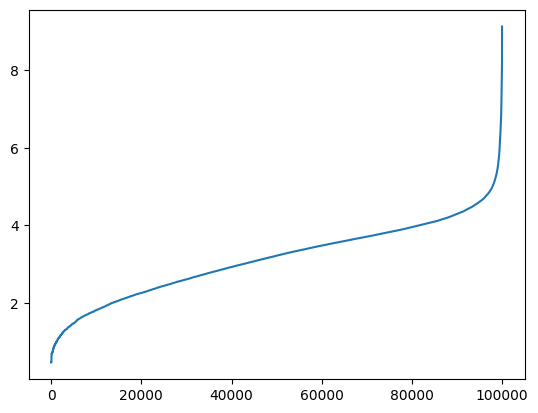

In [30]:
avg_distance = distances.mean(axis=1)
plt.plot(np.sort(avg_distance))

In [31]:
sc = DBSCAN(eps=5, min_samples=180)
clusters = pd.DataFrame(sc.fit_predict(X_train), columns=['Cluster'], index=X_train.index)
clusters['Cluster'].value_counts()

Cluster
 0    94377
-1     3254
 1     2369
Name: count, dtype: int64

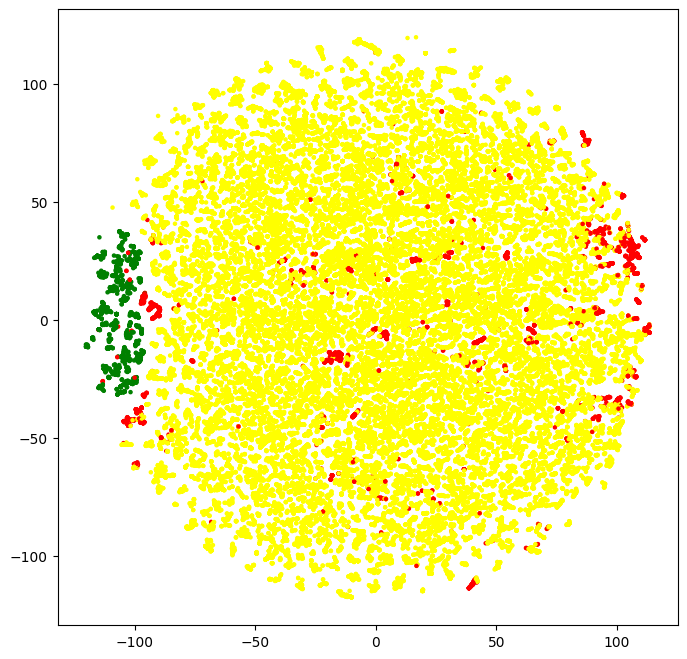

In [32]:
colors = clusters['Cluster'].map({-1: 'red', 0: 'yellow', 1: 'green', 2: 'blue'})
plt.figure(figsize=(8, 8))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=colors, s=5)
plt.show()

In [ ]:
# from sklearn.metrics import silhouette_score
# # Optimal value for eps
# eps = 5
 
# # Range of values for min_samples to explore
# min_samples_range = range(80, 200)
 
# # Initialize a list to save silhouette scores
# silhouette_scores = []
 
# # Compute silhouette score for each min_samples value
# for min_samples in min_samples_range:
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = dbscan.fit_predict(X_train)
#     if len(np.unique(labels)) > 1:  # Ensure there are at least 2 clusters
#         silhouette_avg = silhouette_score(X_train, labels)
#         silhouette_scores.append(silhouette_avg)
#     else:
#         silhouette_scores.append(-1)  # Set a negative score if there's only one cluster
 
# # Find the min_samples value with the maximum silhouette score
# best_min_samples = min_samples_range[np.argmax(silhouette_scores)]
# best_silhouette_score = max(silhouette_scores)
 
# print(f"The best value for min_samples is {best_min_samples} with a silhouette score of {best_silhouette_score}")

The best value for min_samples is 110 with a silhouette score of 0.22400814393834875


In [33]:
opt = BayesSearchCV(
    XGBClassifier(),
    {
        'n_estimators': (2, 200),
        'max_depth': (2, 35),
        # 'gamma': (1e-6, 1e+1, 'log-uniform'),
        # 'reg_lambda': (1, 8, 'uniform'),
        # 'booster': ['gbtree', 'gblinear', 'dart'],
        # "tree_method": ['exact', 'approx', 'hist']
    },
    n_iter=10,
    cv=5,
    scoring='f1'
)

In [34]:
cls = clusters['Cluster'].unique()

models = {}
for c in cls:
    opt.fit(X_train[clusters['Cluster'] == c], y_train[clusters['Cluster'] == c])
    print(f'val. score for {c}: {opt.best_score_}')
    models[c] = opt.best_estimator_
    
models

val. score for 0: 0.9364358812717034
val. score for -1: 0.9248097053654785
val. score for 1: 0.9242871396449971


{0: XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=12, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=115, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 -1: XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_c

In [ ]:
test_clusters = pd.DataFrame(sc.fit_predict(X_test), columns=["Cluster"], index=X_test.index)
X_test["Cluster"] = test_clusters["Cluster"]

# Initialize a dictionary to store predictions
predictions = pd.DataFrame()

# Iterate through clusters and test corresponding models
for c in cls:
    # Get data for the current cluster
    cluster_data = X_test[X_test["Cluster"] == c]
    cluster_labels = y_test[X_test["Cluster"] == c]
    
    if c in models:
        preds = models[c].predict(cluster_data.drop("Cluster", axis=1))
        pd.concat([predictions, preds], axis=0, ignore_index=True)
        predictions.append('idx': cluster_data.index, 'pred': preds)
        predictions.extend(zip(cluster_data.index, preds))
    else:
        print(f"No model available for cluster {c}.")
        
# Combine predictions
predictions.sort(key=lambda x: x[0])  # Sort by index
final_predictions = [pred[1] for pred in predictions]

# Evaluate performance
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions, average='weighted')
recall = recall_score(y_test, final_predictions, average='weighted')
f1 = f1_score(y_test, final_predictions, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.65
Precision: 0.89
Recall: 0.65
F1 Score: 0.74
